In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


df = pd.read_csv("datasets/ames.csv")

/tmp/ipykernel_1029595/2462559147.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

print("Correlation with SalePrice:\n")
print(df[features].corrwith(df.SalePrice))

Correlation with SalePrice:

GarageArea      0.640138
YearRemodAdd    0.532974
TotalBsmtSF     0.632529
GrLivArea       0.706780
dtype: float64


In [3]:
X = df.copy()
y = X.pop("SalePrice")
X = X.loc[:, features]

# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X)
print(loadings)

                   PC1       PC2       PC3       PC4
GarageArea    0.541229  0.102375 -0.038470  0.833733
YearRemodAdd  0.427077 -0.886612 -0.049062 -0.170639
TotalBsmtSF   0.510076  0.360778 -0.666836 -0.406192
GrLivArea     0.514294  0.270700  0.742592 -0.332837


# 1) Create New Features

In [4]:
X = df.copy()
y = X.pop("SalePrice")

# Add new features to X.
X = X.join(X_pca)

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

Your score: 0.13856 RMSLE


In [5]:
X = df.copy()
y = X.pop("SalePrice")

# Add new features to X.
X["Feature1"] = X.GrLivArea + X.TotalBsmtSF
X["Feature2"] = X.YearRemodAdd * X.TotalBsmtSF

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

Your score: 0.13792 RMSLE


/home/gauravjain/projects/sci-kit/scilib/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


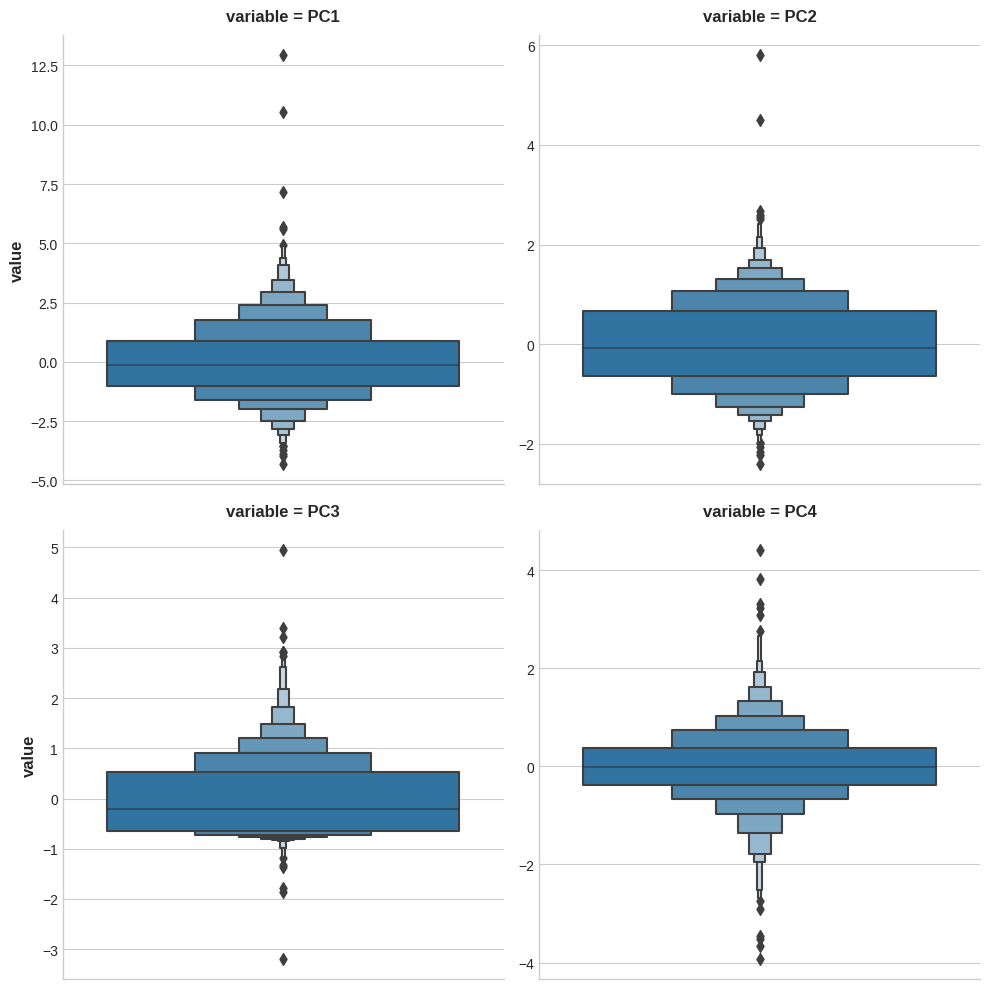

In [6]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [7]:
# You can change PC1 to PC2, PC3, or PC4
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1760,745000,Northridge,Abnorml,813.0,1996,2396.0,4476.0
1767,755000,Northridge,Normal,832.0,1995,2444.0,4316.0
...,...,...,...,...,...,...,...
662,59000,Old_Town,Normal,0.0,1950,416.0,599.0
2679,80500,Brookside,Normal,0.0,1950,0.0,912.0
2879,51689,Iowa_DOT_and_Rail_Road,Abnorml,0.0,1950,0.0,729.0
780,63900,Sawyer,Normal,0.0,1950,0.0,660.0


In [8]:
# You can change PC1 to PC2, PC3, or PC4
component = "PC2"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2561,137900,North_Ames,Normal,528.0,1951,2136.0,2136.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1288,256000,Old_Town,Normal,520.0,1950,1510.0,2792.0
...,...,...,...,...,...,...,...
1283,143000,Old_Town,Abnorml,308.0,2008,192.0,1133.0
1220,52000,Brookside,Normal,0.0,2003,270.0,729.0
243,84900,Edwards,Abnorml,308.0,2006,0.0,930.0
154,107500,North_Ames,Normal,392.0,2007,0.0,827.0


In [9]:
# You can change PC1 to PC2, PC3, or PC4
component = "PC3"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1497,284700,Edwards,Normal,624.0,1996,0.0,3820.0
290,160000,South_and_West_of_Iowa_State_University,Normal,0.0,1967,0.0,2650.0
1537,381000,Crawford,Normal,1014.0,1997,728.0,3447.0
2666,475000,Old_Town,Normal,840.0,1993,1107.0,3608.0
2230,315000,Crawford,Normal,691.0,1986,279.0,2726.0
...,...,...,...,...,...,...,...
1656,170000,Northwest_Ames,Normal,944.0,1971,1625.0,1220.0
1637,591587,Stone_Brook,Partial,1110.0,2007,2660.0,2338.0
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
423,555000,Northridge_Heights,Normal,672.0,2008,3094.0,2402.0


In [10]:
# You can change PC1 to PC2, PC3, or PC4
component = "PC4"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1258,139000,Old_Town,Normal,1488.0,1950,892.0,1436.0
1557,81000,Iowa_DOT_and_Rail_Road,Normal,1248.0,1950,894.0,894.0
746,126500,Brookside,Normal,1184.0,1950,1072.0,1072.0
2282,168000,Mitchell,Normal,1356.0,1975,1249.0,1622.0
2278,130000,Mitchell,Normal,1041.0,1953,0.0,2034.0
...,...,...,...,...,...,...,...
1772,430000,Northridge,Normal,546.0,1993,3200.0,3228.0
2045,200500,Clear_Creek,Normal,0.0,1994,1598.0,3086.0
2194,200000,South_and_West_of_Iowa_State_University,Abnorml,0.0,1995,1440.0,3395.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
